# Table of Contents


1.   [Installing required libraries and data](#scrollTo=iukV7L6lSrMl&line=1&uniqifier=1)
2.   [Word2Vec overview](#scrollTo=rGsFwQBCT_op&line=1&uniqifier=1)
3.   [AG's news dataset](#scrollTo=zNpEhiJATgil&line=1&uniqifier=1)
4.   [Text Preprocessing](#scrollTo=NKa4xUcZUUxv&line=1&uniqifier=1)    
5.   [Featurization of news with Word2Vec](#scrollTo=2uMXRAqONVhW&line=1&uniqifier=1)
6.   [Modelling with Multinomial NB](#scrollTo=Kep8nsKO869a&line=1&uniqifier=1)
7.   [Performance results](#scrollTo=acW1Hhw1Ah_U&line=1&uniqifier=1)
8.   [Useful resources](#scrollTo=9IsIsNtyWWXO&line=1&uniqifier=1)



# Libraries and Data

In [1]:
!pip install gdown
!pip install gensim

In [2]:
#Get news data
!gdown https://drive.google.com/uc?id=1YGJ708knQO6O89yA379NqmITLQsVvuf6
!gdown https://drive.google.com/uc?id=1gtAI6jQt0dhD10TtI53D8ugUWx96vAJS
#Get pretrained word2vec vectors - this file size is 1.5GB, it will take time
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

Downloading...
From: https://drive.google.com/uc?id=1YGJ708knQO6O89yA379NqmITLQsVvuf6
To: /content/train.csv
29.1MB [00:00, 56.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gtAI6jQt0dhD10TtI53D8ugUWx96vAJS
To: /content/test.csv
100% 1.83M/1.83M [00:00<00:00, 58.6MB/s]
--2020-11-13 09:59:34--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.42.206
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.42.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  74.0MB/s    in 27s     

2020-11-13 10:00:01 (58.4 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#some libraries cause this future warnings when the newer versions will be released. To prevent showing them, this code is used.

# WORD2VEC OVERVIEW

In [4]:
from gensim.models import KeyedVectors

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

All word vectors are 300 dimensional dense vectors. 

In [5]:
word2vec["google"].shape

(300,)

Thanks to these dense vectors, semantic and syntactic similarities can be captured between the words because the similar word vectors are closer to each other in the 300-d vector space compared to different words

In [6]:
word2vec.most_similar("cat",topn=3) #top 3 similar word for cat: as seen, cats (syntactic similarity) and dog & kitten (semantic similarity)

[('cats', 0.8099379539489746),
 ('dog', 0.7609456777572632),
 ('kitten', 0.7464985251426697)]

In [7]:
word2vec.most_similar("france",topn=3)

[('spain', 0.6375303268432617),
 ('french', 0.6326056718826294),
 ('germany', 0.6314354538917542)]

By utilizing this relationships, it is possible to create both syntactic and semantic analogies.

In [8]:
def analogy(x1, x2, y1):
    result = word2vec.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [9]:
#semantic analogies
analogy('turkey', 'turkish', 'japan')

'japanese'

In [10]:
#syntactic analogies
analogy('good', 'best', 'long')

'longest'

Let's see the words and their positions in the 2-dimensional vector space by using dimension reduction techniques (PCA)!

In [11]:
import numpy as np
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def display_pca_scatterplot(model, words):
       
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(8,8))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
    plt.show()



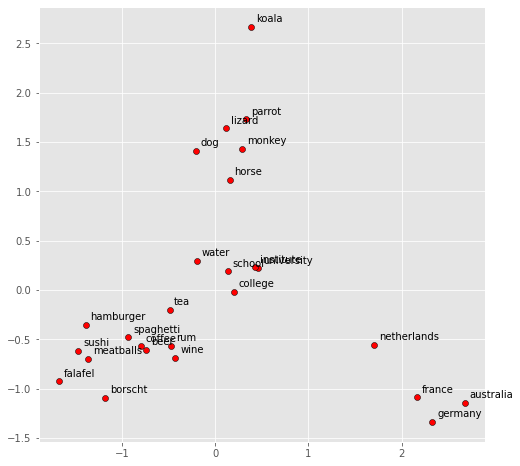

In [12]:
words=['coffee', 'tea', 'beer', 'wine', 'rum', 'water',
      'spaghetti', 'borscht', 'hamburger', 'falafel', 'sushi', 'meatballs',
      'dog', 'horse', 'monkey', 'parrot', 'koala', 'lizard',
      'france', 'germany', 'netherlands', 'australia',
      'school', 'college', 'university', 'institute']
display_pca_scatterplot(word2vec,words)

Quite impressive, dont you think? :)

# AG'S NEWS DATASET

In [60]:
import pandas as pd
df_train = pd.read_csv(r"train.csv")
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print(df_train["Label"].value_counts())
df_test = pd.read_csv(r"test.csv")
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

Number of training sentences: 120,000

4    30000
3    30000
2    30000
1    30000
Name: Label, dtype: int64
Number of test sentences: 7,600



**Classes:**

1:'World News'

2:'Sports News'

3:'Business News'

4:'Science-Technology News'

Training model with 120K takes a lot of time, even with GPU. For this workshop, we will move on with 10K training data and 2K test data.

In [61]:
df_train=df_train.groupby('Label').apply(lambda x: x.sample(frac=1/12,random_state=1)).reset_index(drop=True)
df_train["Label"].value_counts()

4    2500
3    2500
2    2500
1    2500
Name: Label, dtype: int64

In [62]:
df_train.head()

,Label,Title,Description
0,1,"Haitians Pray for 1,500 Killed by Jeanne (AP)",AP - In a cathedral ankle-deep in mud and over...
1,1,"U.S.-Led Forces Tighten Grip, Draw Complaints","SAMARRA, Iraq (Reuters) - U.S.-led forces tig..."
2,1,U.N. Says Bugging Device Found at Its Geneva H...,Reuters - The United Nations said on Thursday ...
3,1,Kerry Questions Bush's Judgment on Iraq,NEW YORK - Sen. John Kerry said Monday that mi...
4,1,Seoul Asks Bush to Focus on N.Korea Nuclear Cr...,South Korean President Roh Moo-hyun called new...


In [63]:
df_test=df_test.groupby('Label').apply(lambda x: x.sample(frac=20/76,random_state=1)).reset_index(drop=True)
df_test["Label"].value_counts()

4    500
3    500
2    500
1    500
Name: Label, dtype: int64

In [64]:
df_test.head()

,Label,Title,Description
0,1,Italian taken hostage in Iraq: report (AFP),AFP - An Italian national working for a Britis...
1,1,Two gored to death in Spanish bull-run,Two Spanish men were gored to death by fightin...
2,1,Zarqawi group claims attack on Australian sold...,AFP - The group loyal to Al-Qaeda-linked milit...
3,1,Washington admits failure to get Iran to UN Se...,VIENNA (MNA) - A United States official confir...
4,1,Bookies take bets on new Band Aid,Bookies take bets on a new Band Aid single bei...


We will feed model with both title and description, rather than choosing only one of them. Therefore, these two text data will be merged.

In [65]:
df_train['Text'] = df_train['Title'] + ' ' + df_train['Description']
df_test['Text'] = df_test['Title'] + ' ' + df_test['Description']

df_train = df_train.drop(columns=['Title', 'Description'])
df_test = df_test.drop(columns=['Title', 'Description'])


# TEXT PREPROCESSING

In [66]:
df_train["Label"]=df_train["Label"].apply(lambda x: x-1)
df_test["Label"]=df_test["Label"].apply(lambda x: x-1)

In [67]:
df_train.Text[0]

'Haitians Pray for 1,500 Killed by Jeanne (AP) AP - In a cathedral ankle-deep in mud and overturned pews, Haitians prayed for 1,500 killed by Tropical Storm Jeanne and gave thanks for their lives  #151; though most lost homes and belongings  #151; while the United Nations rushed in hundreds more peacekeepers to stem looting by gangsters and ordinary citizens of the ravaged city of Gonaives.'

In [68]:
import numpy as np 
import nltk
import string as s
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer=nltk.stem.WordNetLemmatizer()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import  confusion_matrix,classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Lemmatization is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

In [69]:
def preprocess(text,remove_stop_punc=False):
  text=text.lower()
  
  text=text.replace("\n"," ")
  #removing URL
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)

  #Replace &amp, &lt, &gt with &,<,> respectively
  text=text.replace(r'&amp;?',r'and')
  text=text.replace(r'&lt;',r'<')
  text=text.replace(r'&gt;',r'>')

  #remove hashtags
  text=re.sub(r"#[A-Za-z0-9]+","",text)   
  #remove \
  text=re.sub(r"\\ "," ",text)
 
  #remove punctuations and stop words
  stop_words=stopwords.words('english')
  tokens=nltk.word_tokenize(text)
  if remove_stop_punc:
    tokens_new=[i for i in tokens if not i in stop_words and i.isalpha()] #isalpha() method returns True if all the characters are alphabet letters
  else:
    tokens_new=tokens
  tokens_new=[lemmatizer.lemmatize(i) for i in tokens_new]
  #remove excess whitespace
  text= ' '.join(tokens_new)
  return text

df_train["Text"]=df_train["Text"].apply(preprocess,remove_stop_punc=True)
df_test["Text"]=df_test["Text"].apply(preprocess,remove_stop_punc=True)

In [70]:
df_train.Text[0]

'haitian pray for 1,500 killed by jeanne ( ap ) ap - in a cathedral ankle-deep in mud and overturned pew , haitian prayed for 1,500 killed by tropical storm jeanne and gave thanks for their life ; though most lost home and belonging ; while the united nation rushed in hundred more peacekeeper to stem looting by gangster and ordinary citizen of the ravaged city of gonaives .'

##### **BEFORE PREPROCESSING:**

> Haitians Pray for 1,500 Killed by Jeanne (AP) AP - In a cathedral ankle-deep in mud and overturned pews, Haitians prayed for 1,500 killed by Tropical Storm Jeanne and gave thanks for their lives  #151; though most lost homes and belongings  #151; while the United Nations rushed in hundreds more peacekeepers to stem looting by gangsters and ordinary citizens of the ravaged city of Gonaives.

##### **AFTER PREPROCESSING:**

> haitian pray killed jeanne ap ap cathedral mud overturned pew haitian prayed killed tropical storm jeanne gave thanks life though lost home belonging united nation rushed hundred peacekeeper stem looting gangster ordinary citizen ravaged city gonaives




# FEATURE EXTRACTION WITH WORD2VEC

To obtain sentence or news vector representations, the aggregation of word vectors is required. There are lots of approaches in the applications. In this workshop, we will take average of word vectors to represent news. 

Also, in the related function, we add if condition which controls whether the related word exists in vocabular or not because Word2vec may not have all possible word vectors. Therefore, out-of-vocabulary (OOV) problem can occur if words do not exist.

In [71]:
def vocab_control(word):
  if word in word2vec.vocab.keys():
    print("{} exists in the vocabulary".format(word))
  else:
    print("{} does not exist in the vocabulary and it is the example for OOV problem".format(word))

In [72]:
vocab_control("sweden")

sweden exists in the vocabulary


In [73]:
vocab_control("luxemburg")

luxemburg does not exist in the vocabulary and it is the example for OOV problem


In [74]:
from nltk.tokenize import WordPunctTokenizer
WPT = WordPunctTokenizer()

def news_embed(sentence):
    sentence=sentence.lower()
    tokens=WPT.tokenize(sentence)
    new_tokens=[token for token in tokens]

    sent_list=[]
    for word in new_tokens:
        if word in word2vec.vocab.keys():
          wv=word2vec[word]
          sent_list.append(wv)
        else:
          continue
    sent_embed= np.mean(sent_list,axis=0)
    return sent_embed


In [75]:
sentence="Principai offers customized NLP solutions"

In [76]:
a=news_embed(sentence)
a.shape

(300,)

In [77]:
type(a)

numpy.ndarray

In [78]:
texts = df_train.Text
labels = df_train.Label

from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(texts, labels, random_state=42, test_size=0.2)

test_x=df_test.Text
test_y=df_test.Label

In [79]:
train_array=np.array([news_embed(news) for news in train_x])
valid_array=np.array([news_embed(news) for news in valid_x])
test_array=np.array([news_embed(news) for news in test_x])
train_array.shape

(8000, 300)

# MODELLING

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). However, **it requires non-negative inputs.** Since w2v vectors may have negative values, we will apply Linear Support Vector Classifier algorith via [sci-kit learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) library.

In [80]:
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
model = LinearSVC(random_state=0)
model.fit(train_array, train_y)
pred=model.predict(valid_array)
from sklearn.metrics import accuracy_score,confusion_matrix
print("\nAccuracy of W2V and LinearSVC over validation set is:",accuracy_score(valid_y, pred))

print(classification_report(valid_y, pred))


Accuracy of W2V and LinearSVC over validation set is: 0.9045
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       512
           1       0.93      0.98      0.95       500
           2       0.86      0.87      0.87       492
           3       0.90      0.88      0.89       496

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



# PERFORMANCE RESULTS OVER TEST SET

In [81]:
test_pred=model.predict(test_array)

from sklearn.metrics import accuracy_score,confusion_matrix
print("\nAccuracy of W2V and LinearSVC over test set is:",accuracy_score(test_y, test_pred))

print(classification_report(test_y, test_pred))


Accuracy of W2V and LinearSVC over test set is: 0.885
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       500
           1       0.93      0.97      0.95       500
           2       0.84      0.84      0.84       500
           3       0.87      0.86      0.87       500

    accuracy                           0.89      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.88      0.89      0.88      2000



<Figure size 432x288 with 0 Axes>

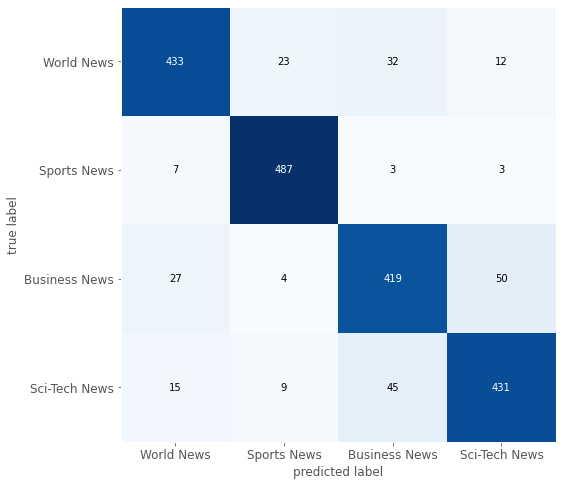

In [82]:
cm  = confusion_matrix(test_y, test_pred)
labels = ['World News', 'Sports News', 'Business News', 'Sci-Tech News']
from mlxtend.plotting import plot_confusion_matrix
plt.figure()
plot_confusion_matrix(cm, figsize=(8,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()

# Testing the model with arbitrary data

In [83]:
def get_prediction(news):
  news=preprocess(news)
  
  news=news_embed(news)
  news=news.reshape(1,-1)
  if model.predict(news)[0]==0:
      topic="TOPIC FOR THIS NEWS IS WORLD"
  elif model.predict(news)[0]==1:
      topic="TOPIC FOR THIS NEWS IS SPORTS"
  elif model.predict(news)[0]==2:
      topic="TOPIC FOR THIS NEWS IS BUSINESS"
  else:
      topic="TOPIC FOR THIS NEWS IS SCIENCE AND TECHNOLOGY"
  return news, topic

World News Source: https://edition.cnn.com/style/article/saqqara-sarcophagi-egypt/index.html

In [84]:
news="Archaeologists unearth 'huge number' of sealed Egyptian sarcophagi Archaeologists in Egypt have discovered another large cache of unopened sarcophagi in Saqqara, adding to the trove of almost 60 coffins recently recovered from the ancient necropolis. Although full details are yet to be announced, authorities said in a statement that a huge number of wooden sarcophagi had been unearthed. The country's Tourism and Antiquities Minister Khaled El-Enany said on Instagram that the find amounted to dozens of coffins, adding that they have been sealed since ancient times. The collection of sarcophagi, stored in three newly discovered burial shafts, is believed to date back more than 2,500 years. Colored and gilded statues were also found in the tombs, a government press release said. On Monday, El-Enany and Egyptian Prime Minister Mostafa Madbouly visited the site alongside secretary general of the Supreme Council of Antiquities, Mustafa Waziri. Photos released by the Ministry of Tourism and Antiquities show the trio being lowered into a shaft before inspecting painted coffins and a variety of other objects."

In [85]:
_ ,topic=get_prediction(news)
print(topic)

TOPIC FOR THIS NEWS IS WORLD


World News Source: https://edition.cnn.com/2020/11/09/middleeast/uae-decriminalize-alcohol-suicide-intl/index.html

In [86]:
news="The United Arab Emirates has introduced a slew of reforms on personal status and penal laws as part of a years-long bid to modernize the Gulf state and promote a progressive brand of Islam. Over the weekend, the oil-rich country announced it had decriminalized alcohol and suicide, and scrapped so-called honor crime provisions that gave men lighter sentences if they assaulted female relatives to protect a family's reputation. Official news reporting about the series of decrees states that the country has 'lifted the criminalization of parts of the penal code that do not harm others' -- a vaguely worded phrase that could signal the further repeal of more socially conservative rules. The UAE has adopted an increasingly liberal approach to social freedoms in recent years, helping to attract expatriates to the country and retain those already living there. Foreigners (around 8 million people in a country of roughly 10 million) make up an overwhelming part of the UAE's workforce."

In [87]:
_ ,topic=get_prediction(news)
print(topic)

TOPIC FOR THIS NEWS IS WORLD


Sport News Source: https://edition.cnn.com/2020/10/19/football/champions-league-group-stage-preview-spt-intl/index.html

In [88]:
news2="Champions League: Can Bayern Munich become just second team in history to retain the trophy? Only one team in Champions League history has previously won back-to-back titles. Real Madrid's all-conquering team, led by Zinedine Zidane, won club football's biggest prize for an unprecedented three consecutive years between 2016 and 2018 -- now Bayern Munich has a realistic chance of doing the same. Few could argue that the perennial German champion was not the best team in Europe last season and a deserving Champions League winner. Hansi Flick's side returned from the coronavirus-enforced break in unstoppable form, winning every remaining game of the season. The most eye-catching victory in the record-breaking 23-game winning streak -- which began against Cologne back in February and ended with defeat to Hoffenheim at the end of September -- was the 8-2 humiliation of Barcelona in the Champions League quarterfinals. It's also been estimated that Bayern could earn over $150 million for winning last season's tournament. Perhaps most concerningly for Bayern's European rivals is that the Bavarian club has arguably only gotten stronger in the off-season. Despite losing midfield maestro Thiago to Liverpool and Philippe Coutinho returning to Barcelona, Bayern has bolstered its ranks with the additions of Leroy Sane from Manchester City and highly-rated Spanish youngster Marc Roca, as well as the return of winger Douglas Costa."

In [89]:
_ ,topic=get_prediction(news2)
print(topic)

TOPIC FOR THIS NEWS IS SPORTS


Tech News Source: https://edition.cnn.com/2020/10/19/tech/iphone-12-mini-battery/index.html

In [90]:
news3="The iPhone 12 Mini's big drawback: A tiny battery Apple claimed there was no difference between the iPhone 12 and the iPhone 12 Mini except for their size and their price. That's not technically true — because the iPhone 12 Mini is so much smaller, it has a significantly tinier battery. Apple says the iPhone 12 Mini gets two hours less battery life than its larger sibling — 15 hours of video playback on the iPhone 12 Mini compared with 17 hours on the iPhone 12. That's still impressive, especially considering some of the iPhone's larger rivals have substantially larger batteries and don't get nearly as much life out of them. Apple has always worked some magic with battery life by making its software and chips work seamlessly together. But lower battery life remains tradeoff of the iPhone 12 Mini. Sure, you're getting the same screen, camera, chip, software and other features for $100 less, in a 5.4-inch package. But when your buddy with the bigger phone is at 20% and you're at 5%, you might be rethinking whether the smaller phone was the right choice."

In [91]:
_ ,topic=get_prediction(news3)
print(topic)

TOPIC FOR THIS NEWS IS SCIENCE AND TECHNOLOGY


Business News Source: https://edition.cnn.com/2020/10/19/investing/biden-housing-market-suburbs/index.html

In [92]:
news4="Biden could benefit from the exodus to suburbs The US housing market has remained red-hot this year during the pandemic as some flee expensive coastal cities for the suburbs. And experts say there could be election consequences. These urban-dwellers likely aren't trying to make a political statement: They're simply looking for more space and cheaper prices. But if more Democrat-leaning voters are suddenly moving to Republican enclaves, that could change the political landscape. 'We don't know the exact political leanings of the people who are leaving, but we know people are leaving blue areas for red areas because expensive coastal cities dont have as much affordable housing,' said Redfin chief economist Daryl Fairweather in an interview with CNN Business. According to research published this month from online real estate brokerage Redfin (RDFN), lower housing costs in red states have driven the trend: The average home price in counties that have tended to vote more for Democrats was $346,000 in August. Houses in red counties had an average price of $209,000. "

In [93]:
_ ,topic=get_prediction(news4)
print(topic)

TOPIC FOR THIS NEWS IS BUSINESS


# USEFUL RESOURCES


*   [Word2Vec paper](https://arxiv.org/pdf/1310.4546.pdf)
*   [Google Word2Vec - Word Vectors](https://code.google.com/archive/p/word2vec/#Pre-trained_word_and_phrase_vectors)
*   [Simple Colab notebook](https://colab.research.google.com/drive/1zuq1I_FudtB2W4OSOWff8ODqfqK8d9-G#scrollTo=Ym8M2wjkf2_e)

